In [2]:
%matplotlib inline
import osmnx as ox
import geopandas as gpd
import networkx as nx
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
ox.config(log_file=True, log_console=True, use_cache=True)

In [ ]:
G0 = ox.graph_from_place('Manhattan Island,New York City, New York, USA', network_type='drive')
G0_projected = ox.project_graph(G0)
fig, ax = ox.plot_graph(G0_projected, fig_height = 15)

In [36]:
import csv
 
node_number = []
node_colcount = []
node_collisioncount = []
for line in open('node_colcount.csv'): 
    clean_line = line.strip()
    data_points = clean_line.split(',')
    p,q = int(data_points[0]), int(data_points[1])
    node_number.append(p)
    node_colcount.append(q)
    node_collisioncount.append([p,q])


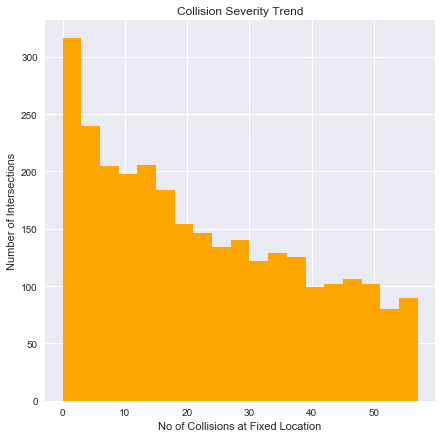

In [9]:
#This graph presents the number of intersections (nodes) corresponding collision count bins

plt.figure(figsize=(7,7))
plt.hist(node_colcount,bins,color = 'orange')
plt.title("Collision Severity Trend")
plt.xlabel("No of Collisions at Fixed Location")
plt.ylabel("Number of Intersections")

plt.show()

In [10]:
def path_and_distance(G,origin_node, destination_node):
    route = nx.shortest_path(G, origin_node, destination_node, weight='length')
    length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
    return route,length

In [11]:
def distance_calculator(G,route):
    p = len(route)-1
    dis = 0
    for i in range (0,(p)):    
        length = nx.shortest_path_length(G, route[i] , route[i+1], weight='length')
        dis+= length
    return dis

In [12]:
def collision_per_mile(G,node_collisioncount,route):
    distance = (distance_calculator(G,route)/1609)
    no_collision = 0
    for u in node_collisioncount:
        if u in route:
            no_collision+= v
    return (no_collision/distance)

In [13]:
def additive_penalty_map(node_number,node_colcount,factor,G):   
    G1 = G.copy()    
    penalty = []
    for i in node_colcount:
        penalty.append(i*20*factor)
                
    counter = 0
    for j in node_number:
        for u,v,d in G1.edges(data=True):
            if (u==j):
                d['length'] = d['length'] + penalty[counter]
        counter +=1
    return G1        

In [47]:
G1 = additive_penalty_map(node_number,node_colcount,0.5,G0)

In [17]:
import random
ODpairs = []

In [32]:
#RUN ME 11 TIMES
for i in range(0,100):
    origin = random.choice(node_number)
    destination = random.choice(node_number)
    dis = nx.shortest_path_length(G0, origin, destination, weight='length')
    if (dis>805):
        k = [origin, destination]
        ODpairs.append(k)
print ("OD pairs Counter: ",len(ODpairs), " pairs")

OD pairs Counter:  1030  pairs


In [33]:
#Using only first 1000 of the OD pairs generated.
ODpairs = ODpairs[:1000]
print ("OD pairs Counter: ",len(ODpairs), " pairs")

OD pairs Counter:  1000  pairs


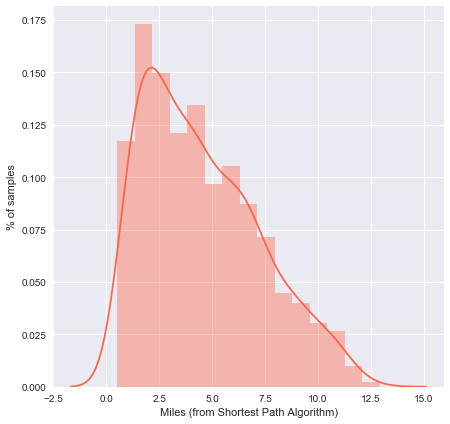

In [34]:
ODpairlengths = []
for i in ODpairs:
    routelength = round((nx.shortest_path_length(G0, i[0], i[1], weight='length'))/1609,2)
    ODpairlengths.append(routelength)

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
plt.ylabel("% of samples")
plt.xlabel("Miles (from Shortest Path Algorithm)")
sns.distplot(ODpairlengths,color="tomato");

In [48]:
dsn = [] #distance
cpm = [] #Collisions per mile
dsn1 = [] #distance -- additive model
cpm1 = [] #Collision per mile -- additive model


for pair in ODpairs:
    r, d = path_and_distance(G0,pair[0], pair[1])
    dsn.append(d/1609)
    cpm.append(collision_per_mile(G0,node_collisioncount,r))

for pair in ODpairs:
    r, d = path_and_distance(G1,pair[0], pair[1])
    dsn1.append(distance_calculator(G0,r)/1609)
    cpm1.append(collision_per_mile(G0,node_collisioncount,r))



In [76]:
dsn = np.array(dsn)
cpm = np.array(cpm)
dsn1 = np.array(dsn1)
cpm1 = np.array(cpm1)

df = pd.DataFrame(dsn)
df.to_csv("dsn.csv")

In [77]:
df = pd.DataFrame(cpm)
df.to_csv("cpm.csv")

df = pd.DataFrame(dsn1)
df.to_csv("dsn1.csv")

df = pd.DataFrame(cpm1)
df.to_csv("cpm1.csv")

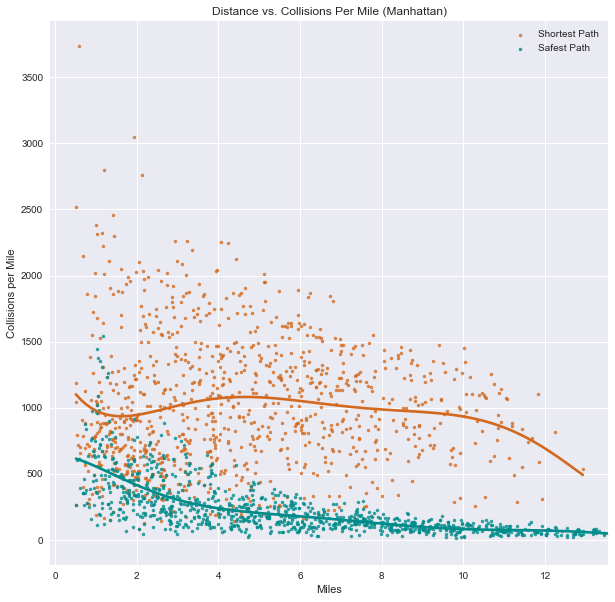

In [154]:
plt.figure(figsize=(10,10))

ax = sns.regplot(x=dsn, y=cpm, label="Shortest Path",
                scatter_kws={"s": 12},
                 order=7, ci=None, truncate=True,color="chocolate")
ax = sns.regplot(x=dsn1, y=cpm1,
                scatter_kws={"s": 12},
                 order=7, ci=None, truncate=True,color="darkcyan",label="Safest Path")
ax.legend(loc="best")

plt.ylabel("Collisions per Mile")
plt.xlabel("Miles")
plt.title("Distance vs. Collisions Per Mile (Manhattan)")
plt.legend()

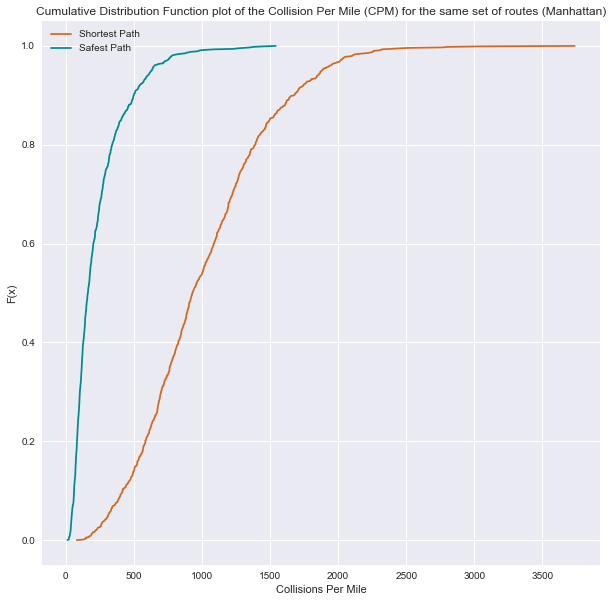

In [158]:
plt.figure(figsize=(10,10))
plt.plot(np.sort(cpm), np.linspace(0,1,(np.sort(cpm)).size),c='chocolate',label="Shortest Path")
plt.plot(np.sort(cpm1), np.linspace(0,1,(np.sort(cpm1)).size),c='darkcyan',label="Safest Path")
plt.legend(loc="best")
plt.ylabel("F(x)")
plt.title("Cumulative Distribution Function plot of the Collision Per Mile (CPM) for the same set of routes (Manhattan)")
plt.xlabel("Collisions Per Mile")
plt.show();

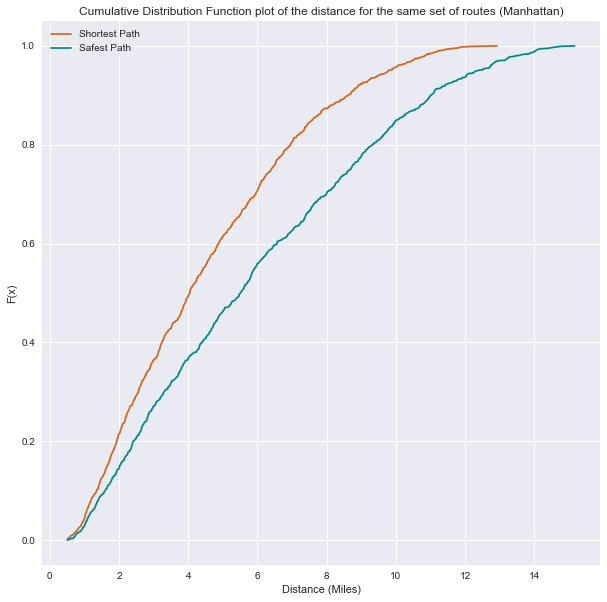

In [160]:
plt.figure(figsize=(10,10))
plt.plot(np.sort(dsn), np.linspace(0,1,(np.sort(cpm)).size),c='chocolate',label="Shortest Path")
plt.plot(np.sort(dsn1), np.linspace(0,1,(np.sort(cpm1)).size),c='darkcyan',label="Safest Path")
plt.legend(loc="best")
plt.ylabel("F(x)")
plt.title("Cumulative Distribution Function plot of the distance for the same set of routes (Manhattan)")
plt.xlabel("Distance (Miles)")
plt.show();

In [161]:
dsnavg = []
cpmavg = []
increase = []
w = np.linspace(0,10,20)
for i in w:
    G1 = additive_penalty_map(node_number,node_colcount,i,G0)
    dsn1 = [] #distance -- additive model
    cpm1 = [] #Collision per mile -- additive model

    for pair in ODpairs:
        r, d = path_and_distance(G1,pair[0], pair[1])
        dsn1.append(distance_calculator(G0,r)/1609)
        cpm1.append(collision_per_mile(G0,node_collisioncount,r))
        
    dsnavg.append(np.average(dsn1))
    cpmavg.append(np.average(cpm1))        

In [220]:
dsnavg = np.round(dsnavg,2)
cpmavg = np.round(cpmavg,2)    

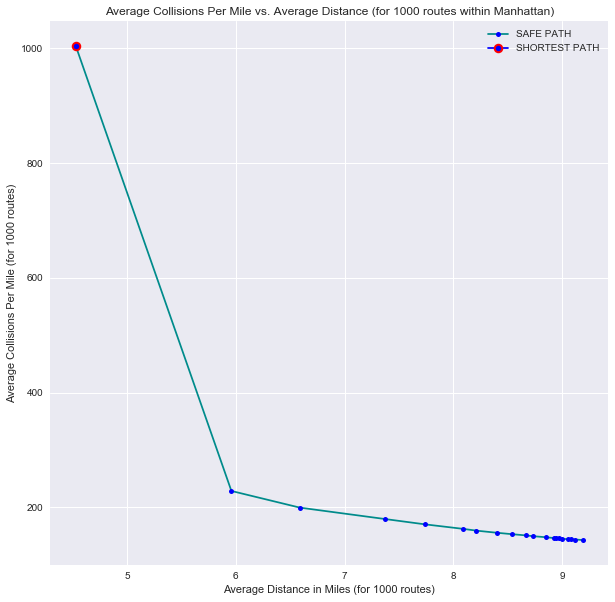

In [242]:
plt.figure(figsize=(10,10))
plt.plot(dsnavg,cpmavg,marker='o', mfc='b',c='darkcyan',ms=5,label="SAFE PATH")
plt.plot(dsnavg[0],cpmavg[0], marker='o', mec='r', mew=2, markersize=7.5, color="b",label="SHORTEST PATH")
plt.legend(loc="best")
plt.ylabel("Average Collisions Per Mile (for 1000 routes)")
plt.title("Average Collisions Per Mile vs. Average Distance (for 1000 routes within Manhattan)")
plt.xlabel("Average Distance in Miles (for 1000 routes)")

plt.show()
